In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import scipy.io
import biosppy
import peakutils
%matplotlib notebook
from matplotlib.widgets import TextBox

<IPython.core.display.Javascript object>


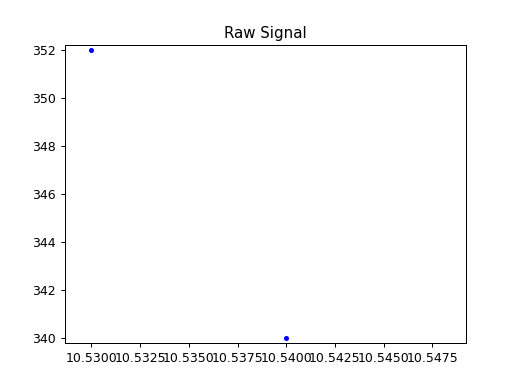

Text(0.5, 1.0, 'Raw Signal')

In [11]:
data_real = pd.read_csv('Sub_Dataset\\subjek1_1.csv')
data = data_real['EKG'].tolist()
ekg_t = data_real['T'].tolist()
plt.figure()

raw_signal = data
raw_signal = np.array(raw_signal)
signal_len = len(raw_signal)
fs = 100
t = np.arange(0,signal_len)/fs
plt.plot(t,raw_signal,'b.')
plt.title('Raw Signal')

In [12]:
#detrend
detrend_signal = scipy.signal.detrend(raw_signal, axis=-1, type='linear', bp=0)

In [13]:
def test_rpeak(signal=None, sampling_rate=1000., threshold=20, before=0.03,
                  after=0.01):
    """ECG R-peak segmentation based on the Slope Sum Function (SSF).

    Parameters
    ----------
    signal : array
        Input filtered ECG signal.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    threshold : float, optional
        SSF threshold.
    before : float, optional
        Search window size before R-peak candidate (seconds).
    after : float, optional
        Search window size after R-peak candidate (seconds).

    Returns
    -------
    rpeaks : array
        R-peak location indices.

    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    # convert to samples
    winB = int(before * sampling_rate)
    winA = int(after * sampling_rate)

    Rset = set()
    length = len(signal)

    # diff
    dx = np.diff(signal)
    dx[dx >= 0] = 0
    dx = dx ** 2

    # detection
    idx, = np.nonzero(dx > threshold)
    idx0 = np.hstack(([0], idx))
    didx = np.diff(idx0)

    # search
    sidx = idx[didx > 1]
    for item in sidx:
        a = item - winB
        if a < 0:
            a = 0
        b = item + winA
        if b > length:
            continue

        r = np.argmax(signal[a:b]) + a
        Rset.add(r)

    # output
    rpeaks = list(Rset)
    rpeaks.sort()
    rpeaks = np.array(rpeaks, dtype='int')

    return rpeaks

In [14]:
multiplier = 2.9
#tres = max(detrend_signal) * multiplier
tres = 200
coba = []
r = test_rpeak(detrend_signal, sampling_rate=fs,threshold=tres,before=0.03,
                  after=0.01)/fs
r

array([ 0.64,  1.38,  2.04,  2.7 ,  3.38,  4.05,  4.75,  5.42,  6.1 ,
        6.8 ,  7.52,  8.23,  8.93,  9.64, 10.31, 10.94, 11.56, 12.17,
       12.8 , 13.41, 14.  , 14.59, 15.17, 15.77, 16.38, 16.99, 17.6 ,
       18.21, 18.82, 19.43, 20.05, 20.65, 21.25, 21.88, 22.49, 23.13,
       23.75, 24.38, 25.  , 25.66, 26.31, 26.95, 27.6 , 28.22, 28.83,
       29.44, 30.06, 30.7 , 31.35, 31.96, 32.58, 33.22, 33.87, 34.53,
       35.18, 35.81, 36.44, 37.07, 37.71, 38.35, 38.97, 39.59, 40.2 ,
       40.85, 41.48, 42.12, 42.74, 43.41, 44.07, 44.73, 45.38, 46.02,
       46.68, 47.33, 47.95, 48.56, 49.16, 49.78, 50.42, 51.05, 51.66,
       52.28, 52.92])

In [15]:
tres

200

<IPython.core.display.Javascript object>


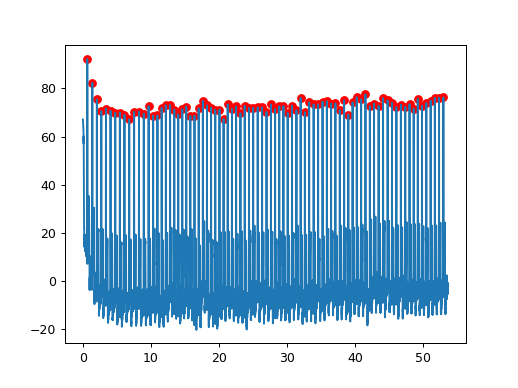

In [16]:
plt.figure()
r_index = []
for i in r:
    r_index.append(np.where(t == i))
    
if r_index == []:
    plt.plot(t,detrend_signal)
else:
    r_index = np.array(r_index)
    plt.plot(t,detrend_signal)
    plt.scatter(t[r_index],detrend_signal[r_index],c='r')

<IPython.core.display.Javascript object>


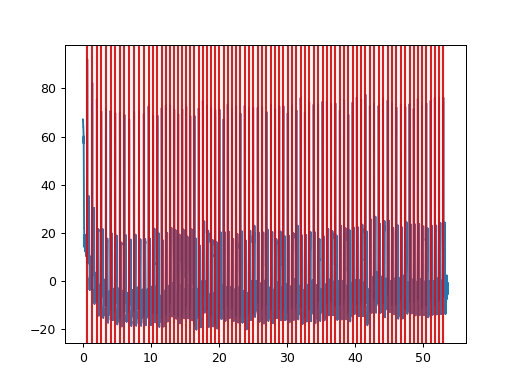

In [17]:
plt.figure()
plt.plot(t,detrend_signal)
for i in r:
    plt.axvline(i,c='r')

<IPython.core.display.Javascript object>


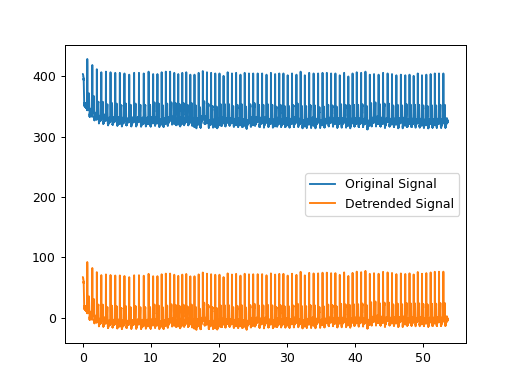

In [18]:
plt.figure()
plt.plot(t,raw_signal)
detrend_signal = scipy.signal.detrend(raw_signal, axis=-1, type='linear', bp=0)
plt.plot(t,detrend_signal)
plt.legend(['Original Signal','Detrended Signal'])

<IPython.core.display.Javascript object>


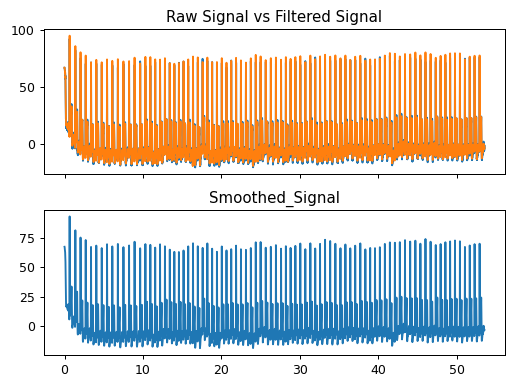

0.8


In [19]:
cutoff = 40 # frekuensi cutoff
nyq = 0.5 * fs
wn = cutoff/(nyq)

b, a = signal.butter(4,wn,btype='low', analog=False)
filtered_signal = signal.filtfilt(b,a,detrend_signal)

smoothed_signal = signal.cspline1d(filtered_signal,lamb=0.3)

fig, ax = plt.subplots(2, sharex = True)
ax[0].plot(t,detrend_signal)
ax[0].plot(t,filtered_signal)

ax[0].set_title('Raw Signal vs Filtered Signal')

ax[1].plot(t,smoothed_signal)
ax[1].set_title('Smoothed_Signal')
print(wn)

plt.tight_layout()

In [26]:
t = np.arange(0,len(raw_signal))/100

<IPython.core.display.Javascript object>


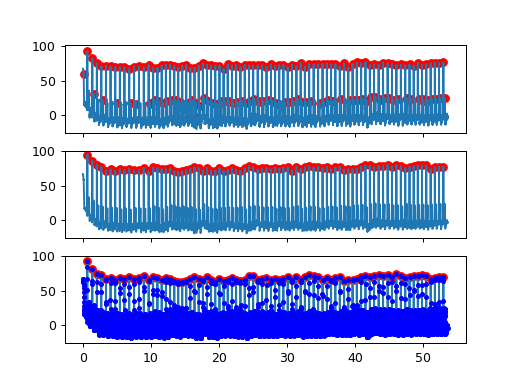

In [20]:
multiplier = 2.9
tres = 100

#rpeak
fig, ax = plt.subplots(3, sharex = True, sharey = True)
raw_rpeak = biosppy.signals.ecg.ssf_segmenter(signal=detrend_signal, sampling_rate=fs, threshold=tres)
raw_rpeak = raw_rpeak['rpeaks']/fs
r_index = []
for i in raw_rpeak:
    r_index.append(np.where(t == i))
    
if r_index == []:
    ax[0].plot(t,detrend_signal)
else:
    r_index = np.array(r_index)
    ax[0].plot(t,detrend_signal)
    ax[0].scatter(t[r_index],detrend_signal[r_index],c='r')


fil_rpeak = biosppy.signals.ecg.ssf_segmenter(signal=filtered_signal, sampling_rate=fs, threshold=tres)
fil_rpeak = fil_rpeak['rpeaks']/fs
r_index2 = []
for j in fil_rpeak:
    r_index2.append(np.where(t == j))
if r_index2 == []:
    ax[1].plot(t,filtered_signal)
else:
    r_index2 = np.array(r_index2)
    ax[1].plot(t,filtered_signal)
    ax[1].scatter(t[r_index2],filtered_signal[r_index2],c='r')


sm_rpeak = biosppy.signals.ecg.ssf_segmenter(signal=smoothed_signal, sampling_rate=100, threshold=tres)
sm_rpeak = sm_rpeak['rpeaks']/fs
r_index3 = []
for k in sm_rpeak:
    r_index3.append(np.where(t == k))
if r_index3 == []:
    ax[2].plot(t, smoothed_signal)
else:
    r_index3 = np.array(r_index3)
    ax[2].plot(t, smoothed_signal)
    ax[2].scatter(t[r_index3],smoothed_signal[r_index3],c='r')

<IPython.core.display.Javascript object>


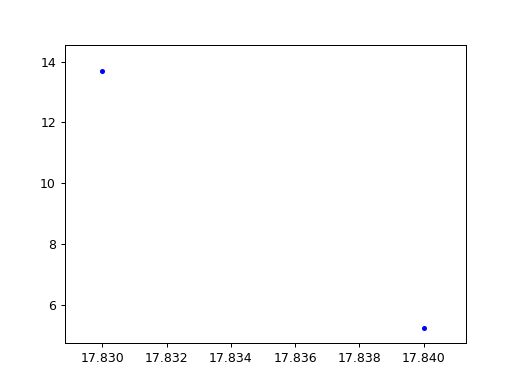

In [24]:
plt.figure()
plt.plot(t,smoothed_signal,'b.')

In [21]:
ssf_rpeak = sm_rpeak
sm_rpeak

array([ 0.65,  1.38,  2.04,  2.7 ,  3.38,  4.05,  4.74,  5.42,  6.09,
        6.8 ,  7.51,  8.23,  8.93,  9.64, 10.31, 10.94, 11.56, 12.18,
       12.8 , 13.42, 14.  , 14.58, 15.17, 15.77, 16.38, 16.99, 17.61,
       18.21, 18.82, 19.43, 20.05, 20.65, 21.25, 21.87, 22.49, 23.13,
       23.75, 24.38, 25.  , 25.65, 26.3 , 26.95, 27.6 , 28.22, 28.82,
       29.43, 30.06, 30.7 , 31.34, 31.96, 32.58, 33.22, 33.87, 34.53,
       35.18, 35.81, 36.43, 37.06, 37.71, 38.35, 38.97, 39.58, 40.2 ,
       40.84, 41.48, 42.12, 42.75, 43.41, 44.07, 44.73, 45.37, 46.02,
       46.67, 47.33, 47.95, 48.56, 49.16, 49.78, 50.41, 51.05, 51.66,
       52.28, 52.92])

In [22]:
RR_interval = np.diff(ssf_rpeak)
RR_interval

array([0.73, 0.66, 0.66, 0.68, 0.67, 0.69, 0.68, 0.67, 0.71, 0.71, 0.72,
       0.7 , 0.71, 0.67, 0.63, 0.62, 0.62, 0.62, 0.62, 0.58, 0.58, 0.59,
       0.6 , 0.61, 0.61, 0.62, 0.6 , 0.61, 0.61, 0.62, 0.6 , 0.6 , 0.62,
       0.62, 0.64, 0.62, 0.63, 0.62, 0.65, 0.65, 0.65, 0.65, 0.62, 0.6 ,
       0.61, 0.63, 0.64, 0.64, 0.62, 0.62, 0.64, 0.65, 0.66, 0.65, 0.63,
       0.62, 0.63, 0.65, 0.64, 0.62, 0.61, 0.62, 0.64, 0.64, 0.64, 0.63,
       0.66, 0.66, 0.66, 0.64, 0.65, 0.65, 0.66, 0.62, 0.61, 0.6 , 0.62,
       0.63, 0.64, 0.61, 0.62, 0.64])

In [30]:
heart_rate = 60/np.mean(RR_interval)
heart_rate

94.12665008609144

In [31]:
SDNN = np.std(RR_interval)
SDNN

0.031070767989195745

In [32]:
NN50 = np.sum(np.abs(np.diff(RR_interval))> 0.05)
pNN50 = (NN50/len(RR_interval)) * 100
pNN50

1.2195121951219512

In [33]:
RMSSD = (np.mean(np.diff(RR_interval) ** 2)) ** 0.5
RMSSD

0.01835856849095359

<IPython.core.display.Javascript object>


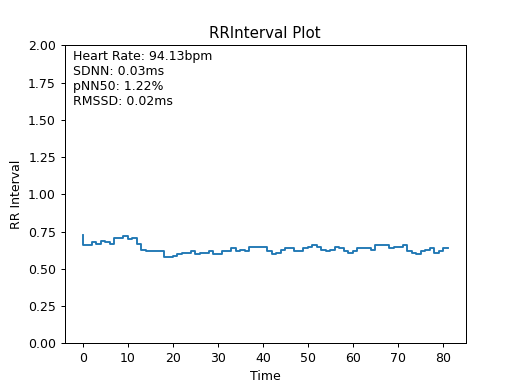

(0.0, 2.0)

In [34]:
plt.figure()
time_test = np.arange(0,len(RR_interval))
plt.step(time_test,RR_interval)
plt.annotate(f'Heart Rate: {heart_rate:.2f}bpm', xy=(0.02,0.95 ), xycoords='axes fraction')
plt.annotate(f'SDNN: {SDNN:.2f}ms', xy=(0.02, 0.90 ), xycoords='axes fraction')
plt.annotate(f'pNN50: {pNN50:.2f}%', xy=(0.02,0.85 ), xycoords='axes fraction')
plt.annotate(f'RMSSD: {RMSSD:.2f}ms', xy=(0.02, 0.80 ), xycoords='axes fraction')
plt.annotate(f'Hasil Klasifikasi')
plt.ylim(-250,500)
plt.pause(0.1)
plt.title('RRInterval Plot')
plt.xlabel('Time')
plt.ylabel('RR Interval')
plt.ylim(0,2)

In [21]:
pNN50 = 9
RMSSD = 0.2

In [54]:
import nn_classifier

pred, pred_prob = nn_classifier.input_fitur(pNN50,RMSSD)
if pred == [0]:
    print(f'Normal Sinus Rythm Detected with score: {pred_prob:.2f}')
else:
    print(f'Arrythmia Detected with score {pred_prob:.2f} ')



Normal Sinus Rythm Detected with score: 0.69
